In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sklearn.covariance as cor

import sklearn.svm as svm
from sklearn.metrics import classification_report as clf_rpt
from sklearn.model_selection import train_test_split


os.chdir('/Users/caojiawu/test')
data = pd.read_csv('train.csv')




# 把每个年龄存活均值打印出来。需要注意的是部分年龄没有人和没有存活的人是不同的,但图中都显示的是0.

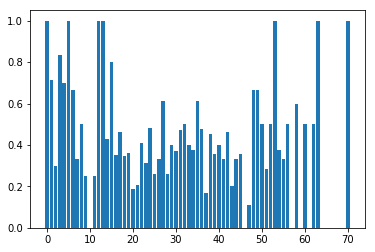

In [2]:
a = data[data['Age'].notnull()][['Survived','Age']]
a['Age'] = a['Age'].astype('int')

b=a.groupby('Age').mean()
plt.bar(range(len(b)),b['Survived'])
plt.show()




# 数据清洗，数据补全
对于可以利用的数据，如果数据是NaN，可以利用已有数据的统计特征进行最小误差引入的补全.

将性别转换为数值型：female=0，male=1.

Embarked取值没有连续性，因此将Embarked做哑变量处理，变成三个特征量：EmbarkedS,EmbarkedC,EmbarkedQ,取值为开关量[0,1]

Pclass同样做哑变量处理，变成三个特征量，Pclass1,Pclass2,Pclass3.



In [3]:
tempData = data

#let female=0 and male=1
tempData['Sex'] = tempData['Sex'].apply(lambda x: 0 if x=='female' else 1)

tempData['Pclass1']=tempData['Pclass'].apply(lambda x: 1 if x==1 else 0)
tempData['Pclass2']=tempData['Pclass'].apply(lambda x: 1 if x==2 else 0)
tempData['Pclass3']=tempData['Pclass'].apply(lambda x: 1 if x==3 else 0)

tempData['EmbarkedC']=tempData['Embarked'].apply(lambda x: 1 if x=='C' else 0)
tempData['EmbarkedQ']=tempData['Embarked'].apply(lambda x: 1 if x=='Q' else 0)
tempData['EmbarkedS']=tempData['Embarked'].apply(lambda x: 1 if x=='S' else 0)


tempData = tempData.drop('PassengerId',1)
tempData = tempData.drop('Name',1)
tempData = tempData.drop('Cabin',1)
tempData = tempData.drop('Ticket',1)
tempData = tempData.drop('Pclass',1)
tempData = tempData.drop('Embarked',1)



# 数据清洗，数据补全
对于无法补全的数据，如果数据为NaN则丢弃整行。

# 对于NaN列，利用其他列的值去预测该值。通过该处理希望可以控制补NaN引入的误差。

In [4]:

tempData_2 = tempData.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

X_train, X_test,y_train,y_test = train_test_split(
    tempData_2[['Sex','Survived','SibSp','Fare','Pclass1','Pclass2','Pclass3','EmbarkedC','EmbarkedQ','EmbarkedS']],
    tempData_2['Age'],test_size=0.25,random_state=35)

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
model = LinearRegression()
#model = SVR(C=1024,gamma=0.5)
model = Ridge(alpha=1.0)
model.fit(X_train,y_train)

u = model.score(X_test,y_test)
print(u)

m = tempData[tempData['Age'].isnull()]
v = model.predict(m[['Sex','Survived','SibSp','Fare','Pclass1','Pclass2','Pclass3','EmbarkedC','EmbarkedQ','EmbarkedS']])

tempData['Age'][tempData['Age'].isnull()] = v

0.229797708712


/Users/caojiawu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [12]:
data[['Survived','Pclass']].groupby('Pclass').mean()
data[['Survived','Embarked']].groupby('Embarked').mean()
data[['Survived','Sex']].groupby('Sex').mean()
data['Pclass'].corr(data['Survived'])

-0.3384810359610147

In [11]:
tempData = tempData.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

X_train, X_test,y_train,y_test = train_test_split(
    tempData[['Sex','Age','SibSp','Fare','Pclass1','Pclass2','Pclass3','EmbarkedC','EmbarkedQ','EmbarkedS']],
    tempData['Survived'],test_size=0.33,random_state=None)

X_train =  X_train.astype('float64')
X_test =  X_test.astype('float64')

from sklearn.ensemble import GradientBoostingClassifier as gbdt
model = gbdt(n_estimators=200)
model.fit(X_train,y_train)
print('gbdt:'+str(model.score(X_test,y_test)))
p = model.predict(X_test)
print(clf_rpt(p,y_test))

from sklearn.linear_model import LogisticRegression 
model = LogisticRegression(penalty='l2')
model.fit(X_train,y_train)
print('LogisticRegression:'+str(model.score(X_test,y_test)))
p = model.predict(X_test)
print(clf_rpt(p,y_test))

from sklearn.ensemble import RandomForestClassifier    
model = RandomForestClassifier(n_estimators=8) 
model.fit(X_train,y_train)
print('RandomForestClassifier:'+str(model.score(X_test,y_test)))
p = model.predict(X_test)
print(clf_rpt(p,y_test))

from sklearn import tree    
model = tree.DecisionTreeClassifier()
model.fit(X_train,y_train)
print('DecisionTree:'+str(model.score(X_test,y_test)))
p = model.predict(X_test)
print(clf_rpt(p,y_test))

from sklearn.svm import SVC    
model = SVC(kernel='rbf', probability=True)   
model.fit(X_train,y_train)
print('SVC:'+str(model.score(X_test,y_test)))
p = model.predict(X_test)
print(clf_rpt(p,y_test))

from sklearn.neighbors import KNeighborsClassifier    
model = KNeighborsClassifier() 
model.fit(X_train,y_train)
print('KNeighborsClassifier:'+str(model.score(X_test,y_test)))
p = model.predict(X_test)
print(clf_rpt(p,y_test))

from sklearn.naive_bayes import MultinomialNB    
model = MultinomialNB(alpha=0.01)  
X_train['Age'] = X_train['Age'].apply(lambda x: 0 if x < 0 else x)
model.fit(X_train,y_train)
print('MultinomialNB:'+str(model.score(X_test,y_test)))
p = model.predict(X_test)
print(clf_rpt(p,y_test))

gbdt:0.850847457627
             precision    recall  f1-score   support

          0       0.95      0.83      0.89       206
          1       0.70      0.89      0.78        89

avg / total       0.87      0.85      0.86       295

LogisticRegression:0.789830508475
             precision    recall  f1-score   support

          0       0.88      0.80      0.84       200
          1       0.65      0.77      0.70        95

avg / total       0.80      0.79      0.79       295

RandomForestClassifier:0.816949152542
             precision    recall  f1-score   support

          0       0.92      0.81      0.86       208
          1       0.65      0.84      0.73        87

avg / total       0.84      0.82      0.82       295

DecisionTree:0.813559322034
             precision    recall  f1-score   support

          0       0.88      0.83      0.85       195
          1       0.70      0.79      0.74       100

avg / total       0.82      0.81      0.82       295

SVC:0.738983050847
 

In [227]:
X_train[X_train['Age']<0]

,Sex,Age,SibSp,Fare,Pclass1,Pclass2,Pclass3,EmbarkedC,EmbarkedQ,EmbarkedS
846,1.0,-8.464977,8.0,69.55,0.0,0.0,1.0,0.0,0.0,1.0
201,1.0,-8.464977,8.0,69.55,0.0,0.0,1.0,0.0,0.0,1.0
